# Sheet 3 - Simulation Exercise (Probit Model - Gibbs and M-H)

In [202]:
using Distributions, StatsPlots, Plots, StatsBase, LinearAlgebra, GraphRecipes
using GaussianMixtures
using LaTeXStrings
pyplot()

┌ Info: Precompiling GraphRecipes [bd48cda9-67a9-57be-86fa-5b3c104eda73]
└ @ Base loading.jl:1192


Plots.PyPlotBackend()

In the probit model we have the similar situation that we have for the linear regression,
hence:
$$
Y = \beta_0 + \beta_1 x_1 + ... + \beta_n x_n
$$
But $Y = 0$ or $1$, so we have to transform the linear equation to fall between 0 and 1.
To do that, we use the cdf for the normal distribution.
$$
Y = \phi(\beta_0 + \beta_1 x_1 + ... + \beta_n x_n)
$$
Note that the cdf will guarantee a value between 0 and 1.

1. Generate a synthetic dataset Y from the probit model for an arbitrary value of β and a matrix X.

In [518]:
n    = 50
beta = [1 -1]
X    = [rand(Normal(0,1),n,1) rand(Normal(0,2),n,1)]

# cdf.(Normal(0,1),X)
# X' * beta
Y = (cdf.(Normal(0,1),X*beta') .>= 0.5).*1;
C = countmap(Y[:])

Dict{Int64,Int64} with 2 entries:
  0 => 29
  1 => 21

2. Introduce the prior distribution on β:
$$\pi(\beta) = N (0, B)$$
for a p × p covariance matrix B. Write a function taking a vector β as argument and returning the log
posterior density function evaluated at β.

Note that
$$
p(\beta \mid Y) \propto \pi(\beta)\prod^n_{i=1}\phi(X_i^T\beta)^{y_i}(1-\phi X_i^T \beta)^{1-y_i}
$$


In [519]:
B = [1.0 0;
     0 1.0]

function LogPosterior(beta)
    post = Y'*logcdf.(Normal(0,1),X*beta') + (1 .- Y)'* logcdf.(Normal(0,1),-X*beta').+ logpdf(MvNormal(B),beta')
    return post[1]
    
end
beta1 = 1.0
beta2 = 5.0
LogPosterior(beta)

-8.800361172509344

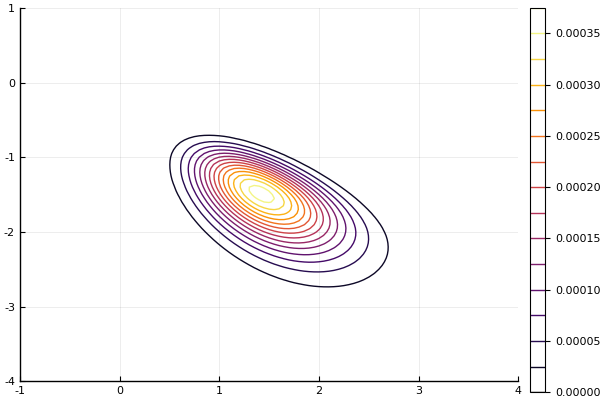

In [677]:
y = -4:0.05:1
x = -1:0.05:4
gridx = repeat(reshape(x, 1, :), length(y), 1)
gridy = repeat(y, 1, length(x))
f(x,y)= exp(LogPosterior([x y]))
Z = map(f, gridx, gridy)
p1 = contour(x,y, f, fill=false)


3. Run Metropolis-Hastings

Sample $X^*$ from $q(\cdot \mid X_{t-1})$, where $q$ is a random walk centered at $X_{t-1}$. We then accept the new step
with probability $\alpha = min\{1, \frac{\pi(X^*)}{\pi(X_{t-1})} \}$

In [657]:
# Sample X
steps = 10_00
C = zeros(steps,length(beta))
Xprevious   = [0;0]

for i=1:steps
    Xnew        = Xprevious + randn(2)
    alpha = minimum([1,exp(LogPosterior(Xnew') - LogPosterior(Xprevious'))])
#     println(1 - alpha, Xnew)
    if rand() < (1 - alpha) # Reject
        Xnew = Xprevious
    end
    C[i,:] = Xnew
    Xprevious = Xnew
end

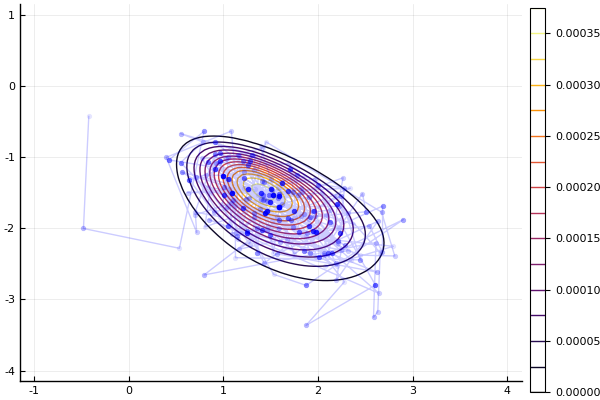

In [676]:
contour(x,y, f, fill=false)
plot!(C[:,1],C[:,2],marker=:o,color=:blue,alpha=0.2, markeralpha = 0.1, markerstrokewidth=0,legend=false)

4. For all i = 1, . . . , n, introduce the random variable $Z_i$ distributed as $N (X^T_i \beta, 1)$. Compare the law of
$\mathbb 1_{Z_i≥0}$ with the law of $Y_i$. 

First, note that $Z_i > 0$, when $Y_i =1$, and $Z_i \leq 0$ otherwise.

In [693]:
# TruncatedNormal()
TruncatedNormal((X*beta')[1],1,-Inf,0) # If Y_i = 0
TruncatedNormal((X*beta')[1],1,0,Inf) # If Y_i = 1

Truncated(Normal{Float64}(μ=-3.0532531909243614, σ=1.0), range=(0.0, Inf))

5. Use Z to design a Gibbs sampler, alternatively sampling from β given Z, Y and from Z given β, Y
$$p(\beta \mid Z, Y) = N(\tilde \mu, \tilde \Sigma)$$
Where, $\tilde \Sigma^{-1} = \Sigma^{-1} + \sum^m_{i=1}x_ix_i^T$,
$\tilde \mu = \tilde \Sigma(\Sigma^{-1}\mu + \sum^n_{i=1}x_iz_i)$

In [774]:
function Sample_Z_Posterior(Y,X,beta)
    Z = zeros(n)
    for i= 1:n
        if Y[i]>0
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,0,Inf)) # If Y_i = 1
        else
            Z[i] = rand(TruncatedNormal((X[i,:]'*beta')[1],1,-Inf,9)) # If Y_i = 0
        end
    end 
    return Z
end
Sample_Z_Posterior(Y,X,beta);

function Sample_beta_posterior(Z,X)
    B_tilde  = inv(inv(B) + X' * X)
    mu_tilde = B_tilde * (X'*Z)
    return rand(MvNormal(mu_tilde, B_tilde))'
end
Sample_beta_posterior(Z,X)

1×2 Adjoint{Float64,Array{Float64,1}}:
 1.07292  -1.11675

1×2 Adjoint{Float64,Array{Float64,1}}:
 1.03305  -1.0977